In [97]:
import pandas as pd
import sys
sys.path.append(str(Path("..").resolve()))
import os
from pathlib import Path
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from mlforecast import MLForecast
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae
from src.data.feature_engineering import date_features, lags


## 1️⃣ Data preparation

In [98]:
import pandas as pd 



def prepare_df(df, unique_id='A'):

    df = df.copy()  
    df['ds'] = pd.to_datetime(df['Datetime']) 
    df['y'] = df['PJME_MW']                    
    df['unique_id'] = unique_id              
    df = df[['ds', 'y', 'unique_id']].sort_values('ds')  
    return df

In [99]:
# -------------------------------
# 1.1 Data Prepartion for Nixtla
# -------------------------------

PROJECT_ROOT = Path.cwd() 
raw_path = os.path.join(PROJECT_ROOT, 'data', 'raw', 'PJME_hourly.csv')  

raw_path =r'C:\Users\Guest\Desktop\ds-projects\Energy-Forecasting\data\raw\PJME_hourly.csv'


df= pd.read_csv(raw_path)  # raw CSV  
df = prepare_df(df)                      # clean, rename, add unique_id
print("Preprocessed data sample:")
print(df.head())

Preprocessed data sample:
                      ds        y unique_id
8734 2002-01-01 01:00:00  30393.0         A
8735 2002-01-01 02:00:00  29265.0         A
8736 2002-01-01 03:00:00  28357.0         A
8737 2002-01-01 04:00:00  27899.0         A
8738 2002-01-01 05:00:00  28057.0         A


In [100]:
# -------------------------------
# 1.2 Split into train and test
# -------------------------------
split_date = '2017-01-01'

train = df[df['ds'] < split_date ]
test  = df[df['ds'] >= split_date ]

print(f'Train shape: {train.shape}, Test shape: {test.shape}')

Train shape: (131470, 3), Test shape: (13896, 3)


In [101]:
train.tail()

,ds,y,unique_id
122705,2016-12-31 19:00:00,34478.0,A
122706,2016-12-31 20:00:00,33328.0,A
122707,2016-12-31 21:00:00,32197.0,A
122708,2016-12-31 22:00:00,30909.0,A
122709,2016-12-31 23:00:00,29519.0,A


In [102]:
test.head()

,ds,y,unique_id
122710,2017-01-01 00:00:00,28171.0,A
140207,2017-01-01 01:00:00,26879.0,A
140208,2017-01-01 02:00:00,25848.0,A
140209,2017-01-01 03:00:00,25039.0,A
140210,2017-01-01 04:00:00,24637.0,A


## 2️⃣ Models Training

In [103]:


models = {
                'lreg': LinearRegression(),
                'dt': DecisionTreeRegressor(),
                'xgb': xgb.XGBRegressor()
}


ml = MLForecast(
                freq='h',
                models=models,
                lags=[1, 24],
                date_features=['dayofweek', 'hour'],

)


In [104]:

print(f'>>Training models ...')
ml.fit(train,static_features=[] )
print(f'✅ Models trained successfully')


>>Training models ...
✅ Models trained successfully


In [106]:

df_pred =ml.predict(h=len(test))
df_pred.head()


,unique_id,ds,lreg,dt,xgb
0,A,2017-01-01 00:00:00,29368.836295,27669.0,27738.619141
1,A,2017-01-01 01:00:00,28927.511135,26144.0,26032.808594
2,A,2017-01-01 02:00:00,28400.590157,25204.0,24807.656250
3,A,2017-01-01 03:00:00,27894.950855,24694.0,24074.085938
4,A,2017-01-01 04:00:00,27481.996687,24438.0,23674.230469


In [107]:
print( 'predictions length :' , df_pred.shape )
print( 'test length :' , test.shape )

predictions length : (13896, 5)
test length : (13896, 3)


## 4️⃣ Evaluation and plotting

In [108]:
merg_df = pd.merge(df_pred,test, on =['unique_id', 'ds'],how='left')
eval_df = evaluate(merg_df,metrics= [mae])
eval_df.head()

,unique_id,metric,lreg,dt,xgb
0,A,mae,4895.650008,5946.007845,4059.442165


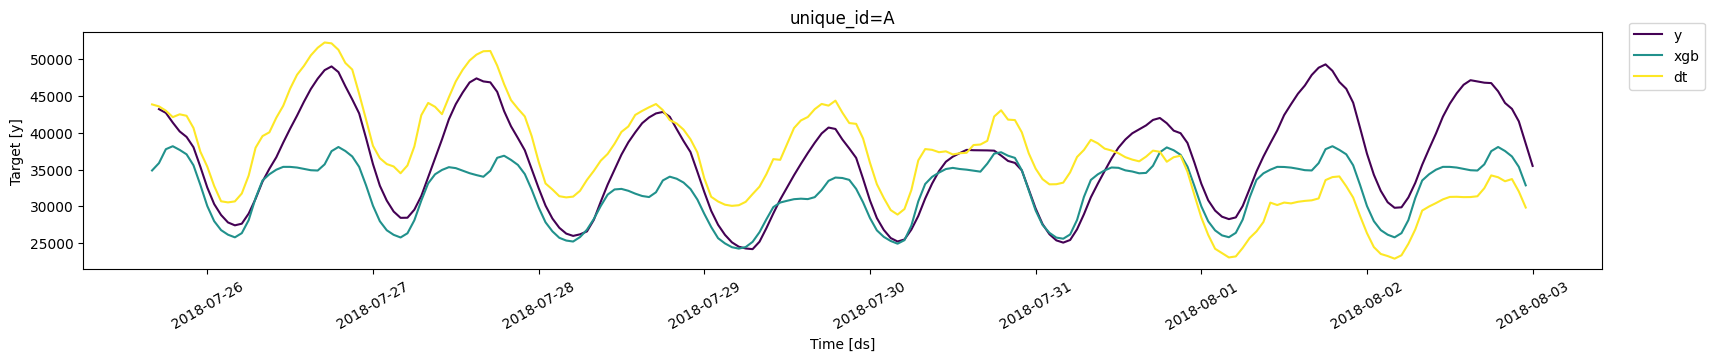

In [109]:
# 3.2 plotting

from utilsforecast.plotting import plot_series


plot_series(df=test, 
                forecasts_df=df_pred[-200:], 
                max_insample_length=200, 
                palette='viridis', 
                models=['xgb','dt'])